In [1]:
import lightgbm as lgb

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
data=np.random.rand(500,10)

In [5]:
label=np.random.randint(2,size=500)
train_data=lgb.Dataset(data,label=label)

In [5]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl,plt

In [6]:
plt.style.use('seaborn')
mpl.rcParams['font.family']='serif'
%matplotlib inline

In [7]:
raw=pd.read_csv("tr_eikon_eod_data.csv",index_col=0,parse_dates=True)

In [8]:
symbol='EUR='

In [9]:
data=pd.DataFrame(raw[symbol])

In [10]:
data['returns']=np.log(data/data.shift(1))


In [11]:
data.dropna(inplace=True)

In [12]:
data['direction']=np.sign(data['returns'])

In [13]:
def create_lag(data):
    global cols_
    cols_=[]
    for lag in range(1,lags+1):
        col='lag_{}'.format(lag)
        data[col]=data['returns'].shift(lag)
        cols_.append(col)

In [14]:
lags=5
create_lag(data)
data.dropna(inplace=True)

In [15]:
def create_bins(data,bins=[0]):
    global cols_bin
    cols_bin=[]
    for col in cols_:
        col_bin=col+'_bin'
        data[col_bin]=np.digitize(data[col],bins=bins)
        cols_bin.append(col_bin)

In [16]:
create_bins(data)

In [17]:
data.dropna(inplace=True)

In [18]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [19]:
C=1

In [20]:
models={'log_reg':linear_model.LogisticRegression(C=C),
       'gauss_nb':GaussianNB(),
       'svm':SVC(C=C)}

In [30]:
def fit_models(data):
    mfit={model:models[model].fit(data[cols_bin],data['direction']) for model in models.keys()}

In [27]:
fit_models(data)

C:\An\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\An\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\An\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [21]:
def dposition(data):
    for model in models.keys():
        data['pos_'+model]=models[model].predict(data[cols_bin])

In [29]:
dposition(data)

In [22]:
def evaluate(data):
    global sel
    sel=[]
    for model in models.keys():
        col='strat_'+model
        data[col]=data['pos_'+model]*data['returns']
        sel.append(col)
    sel.insert(0,'returns')

In [31]:
evaluate(data)

In [32]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin,pos_log_reg,pos_gauss_nb,pos_svm,strat_log_reg,strat_gauss_nb,strat_svm
Date,,,,,,,,,,,,,,,,,,,
2010-01-11,1.4513,0.006984,1.0,0.006544,-0.006544,0.003058,-0.002988,0.006125,1,0,1,0,1,-1.0,-1.0,1.0,-0.006984,-0.006984,0.006984
2010-01-12,1.4494,-0.001310,-1.0,0.006984,0.006544,-0.006544,0.003058,-0.002988,1,1,0,1,0,-1.0,-1.0,-1.0,0.001310,0.001310,0.001310
2010-01-13,1.4510,0.001103,1.0,-0.001310,0.006984,0.006544,-0.006544,0.003058,0,1,1,0,1,1.0,1.0,1.0,0.001103,0.001103,0.001103
2010-01-14,1.4502,-0.000551,-1.0,0.001103,-0.001310,0.006984,0.006544,-0.006544,1,0,1,1,0,-1.0,-1.0,-1.0,0.000551,0.000551,0.000551
2010-01-15,1.4382,-0.008309,-1.0,-0.000551,0.001103,-0.001310,0.006984,0.006544,0,1,0,1,1,1.0,1.0,1.0,-0.008309,-0.008309,-0.008309


In [33]:
sel

['returns', 'strat_log_reg', 'strat_gauss_nb', 'strat_svm']

In [34]:
import lightgbm as lgb

In [36]:
import numpy as np

from sklearn.model_selection import train_test_split


In [38]:
data['modified']=data.direction+1

In [39]:
X_train, X_test, y_train, y_test=train_test_split(data[cols_], data['modified'], test_size=0.33, random_state=42)

In [40]:
lgb_train=lgb.Dataset(X_train,y_train)
lgb_eval=lgb.Dataset(X_test,y_test,reference=lgb_train)
params = {    'objective': 'multiclass',
    'num_class':3,
    'metric': 'multi_logloss'}
gbm=lgb.train(params,train_set=lgb_train,num_boost_round=20,
             valid_sets=lgb_eval,early_stopping_rounds=5)
ypred=gbm.predict(data[cols_bin])
best_ = [np.argmax(line) for line in ypred]

In [42]:
gbm=lgb.train(params,train_set=lgb_train,num_boost_round=20,
             valid_sets=lgb_eval,early_stopping_rounds=5)

[1]	valid_0's multi_logloss: 0.717162
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 0.718707
[3]	valid_0's multi_logloss: 0.720178
[4]	valid_0's multi_logloss: 0.721021
[5]	valid_0's multi_logloss: 0.722527
[6]	valid_0's multi_logloss: 0.723879
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.717162


In [43]:
ypred=gbm.predict(data[cols_])

In [44]:
best_ = [np.argmax(line) for line in ypred]

In [45]:
data['lightgbm']=best_

In [47]:
data.lightgbm-=1

In [48]:
data['lightgbmstrat']=data.lightgbm*data.returns

In [50]:
sel.insert(-1,'lightgbmstrat')

In [53]:
data[sel].sum().apply(np.exp)

returns           0.810644
strat_log_reg     1.191997
strat_gauss_nb    1.191997
lightgbmstrat     7.525237
strat_svm         1.869153
dtype: float64

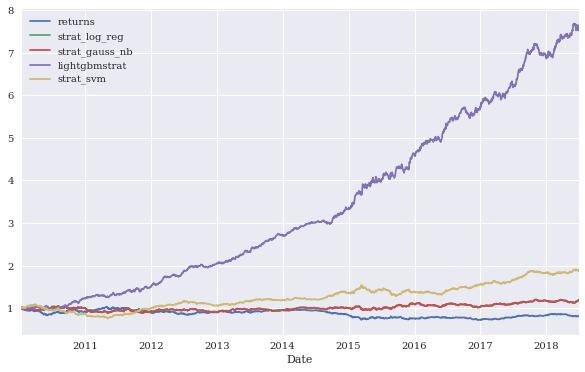

In [54]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

In [23]:
mu=data.returns.mean()
v=data['returns'].std()

In [24]:
bins=[mu-v,mu,mu+v]
bins

[-0.00592426939887045, -9.498932088272995e-05, 0.005734290757104989]

In [25]:
create_bins(data,bins)

In [58]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,3,0,2,1,3
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3


In [62]:
def lgbm(data):
    X_train, X_test, y_train, y_test=train_test_split(data[cols_bin], data['modified'], test_size=0.33, random_state=42)
    lgb_train=lgb.Dataset(X_train,y_train)
    lgb_eval=lgb.Dataset(X_test,y_test,reference=lgb_train)
    params = {    'objective': 'multiclass',
        'num_class':3,
        'metric': 'multi_logloss'}
    gbm=lgb.train(params,train_set=lgb_train,num_boost_round=20,
                 valid_sets=lgb_eval,early_stopping_rounds=5)
    ypred=gbm.predict(data[cols_bin])
    best_ = [np.argmax(line) for line in ypred]
    return best_

    

In [63]:
fit_models(data)
dposition(data)
evaluate(data)

C:\An\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\An\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\An\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [65]:
ybest=lgbm(data)

[1]	valid_0's multi_logloss: 0.717131
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 0.717444
[3]	valid_0's multi_logloss: 0.71812
[4]	valid_0's multi_logloss: 0.718731
[5]	valid_0's multi_logloss: 0.719332
[6]	valid_0's multi_logloss: 0.719732
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.717131


In [66]:
data['l']=ybest

In [68]:
data.l-=1

Date
2010-01-11    1
2010-01-12   -1
2010-01-13   -1
2010-01-14   -1
2010-01-15    1
2010-01-18   -1
2010-01-19   -1
2010-01-20    1
2010-01-21    1
2010-01-22    1
2010-01-25    1
2010-01-26   -1
2010-01-27    1
2010-01-28    1
2010-01-29    1
2010-02-01    1
2010-02-02   -1
2010-02-03    1
2010-02-04    1
2010-02-05    1
2010-02-08    1
2010-02-09    1
2010-02-10    1
2010-02-11   -1
2010-02-12    1
2010-02-15    1
2010-02-16    1
2010-02-17    1
2010-02-18    1
2010-02-19   -1
             ..
2018-05-21    1
2018-05-22   -1
2018-05-23    1
2018-05-24    1
2018-05-25   -1
2018-05-28    1
2018-05-29    1
2018-05-30   -1
2018-05-31    1
2018-06-01    1
2018-06-04    1
2018-06-05    1
2018-06-06    1
2018-06-07    1
2018-06-08   -1
2018-06-11    1
2018-06-12   -1
2018-06-13    1
2018-06-14    1
2018-06-15    1
2018-06-18    1
2018-06-19    1
2018-06-20    1
2018-06-21    1
2018-06-22   -1
2018-06-25    1
2018-06-26   -1
2018-06-27    1
2018-06-28   -1
2018-06-29   -1
Name: l, Length: 22

In [70]:
data['ls']=data.l*data.returns

In [72]:
sel.insert(-1,'ls')

In [73]:
data[sel].sum().apply(np.exp)

returns           0.810644
strat_log_reg     1.520599
strat_gauss_nb    1.437281
ls                3.168580
strat_svm         4.126232
dtype: float64

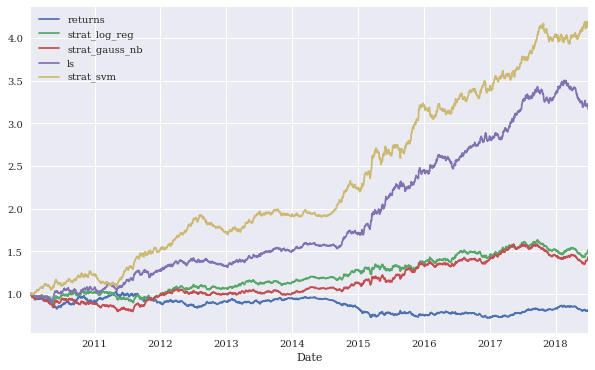

In [74]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [75]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [78]:
timeseries.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [26]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,,,,,,,,,
2010-01-11,1.4513,0.006984,1.0,0.006544,-0.006544,0.003058,-0.002988,0.006125,3,0,2,1,3
2010-01-12,1.4494,-0.001310,-1.0,0.006984,0.006544,-0.006544,0.003058,-0.002988,3,3,0,2,1
2010-01-13,1.4510,0.001103,1.0,-0.001310,0.006984,0.006544,-0.006544,0.003058,1,3,3,0,2
2010-01-14,1.4502,-0.000551,-1.0,0.001103,-0.001310,0.006984,0.006544,-0.006544,2,1,3,3,0
2010-01-15,1.4382,-0.008309,-1.0,-0.000551,0.001103,-0.001310,0.006984,0.006544,1,2,1,3,3


In [27]:
#split

In [28]:
split=int(len(data)*0.5)

In [29]:
train=data.iloc[:split].copy()

In [31]:
fit_models(train)

C:\An\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\An\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\An\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [32]:
test=data.iloc[split:].copy()

In [33]:
dposition(test)

In [34]:
evaluate(test)

In [36]:
test[sel].sum().apply(np.exp)

returns           0.852649
strat_log_reg     1.039327
strat_gauss_nb    1.183389
strat_svm         0.983701
dtype: float64

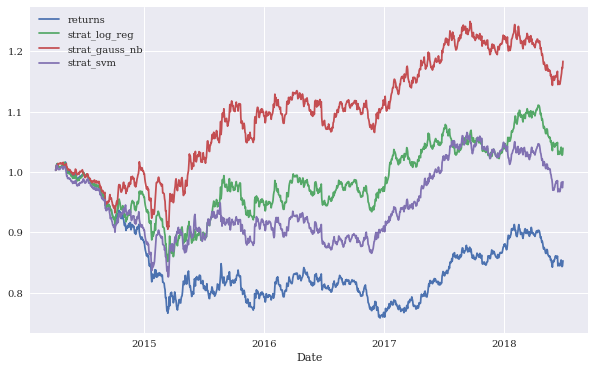

In [38]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
train,test=train_test_split(data,test_size=0.3,shuffle=True,
                           random_state=100)

In [42]:
train=train.copy().sort_index()

In [43]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,3,0,2,1,3
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-18,0,1,2,1,3


In [44]:
test=test.copy().sort_index()

In [45]:
fit_models(train)

C:\An\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\An\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\An\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [46]:
dposition(test)

In [47]:
evaluate(test)

In [48]:
test[sel].sum().apply(np.exp)

returns           0.806292
strat_log_reg     1.160506
strat_gauss_nb    1.033637
strat_svm         1.007905
dtype: float64

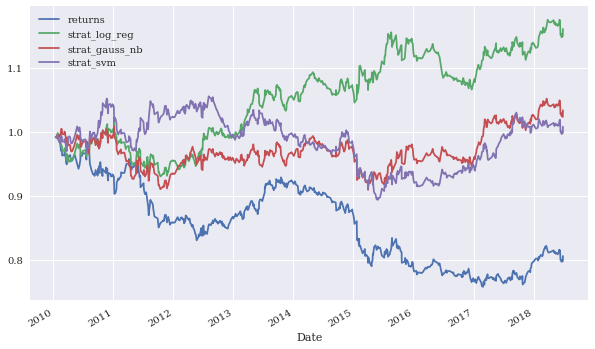

In [49]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

In [50]:
#DeepLearning

In [51]:
from sklearn.neural_network import MLPClassifier

In [52]:
model=MLPClassifier(solver='lbfgs',
                   alpha=1e-5,
                   hidden_layer_sizes=2*[250],
                   random_state=1)

In [53]:
%time model.fit(data[cols_bin],data['direction'])

Wall time: 12.9 s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[250, 250], learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [56]:
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
beta_1=0.9,beta_2=0.999, early_stopping=False, epsilon=1e-08,
hidden_layer_sizes=[250, 250], learning_rate='constant',
learning_rate_init=0.001, max_iter=200, momentum=0.9,
n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
validation_fraction=0.1, verbose=False, warm_start=False)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[250, 250], learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [57]:
data['DNN']=model.predict(data[cols_bin])

In [58]:
data['DNN_strat']=data["DNN"]*data['returns']

In [59]:
data[['returns','DNN_strat']].sum().apply(np.exp)

returns       0.810644
DNN_strat    32.110623
dtype: float64